In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from utils.fingerprinter import Fingerprinter

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

%load_ext autoreload
%autoreload 2

## Data

In [2]:
train_X = pd.read_csv('../data/transformed/train/smiles.csv')
train_Y = pd.read_csv('../data/transformed/train/y.csv')
train_STD = pd.read_csv('../data/transformed/train/std.csv')

test_X = pd.read_csv('../data/transformed/test/smiles.csv')
test_Y = pd.read_csv('../data/transformed/test/y.csv')

properties = train_Y.columns

fingerprinter = Fingerprinter()
train_X = fingerprinter(train_X.to_numpy().squeeze().tolist())
test_X = fingerprinter(test_X.to_numpy().squeeze().tolist())

## Augmented Data

In [3]:
n_samples = 16

augmented_train_X = np.tile(train_X, (n_samples, 1))

augmented_train_Y = np.concatenate([
    train_Y.to_numpy() + np.random.randn(*train_Y.shape) * train_STD.to_numpy()
    for _ in range(n_samples)
])

## XGB Model

In [4]:
with open('./hyperparameters/optimized_multi/xgbr.json') as f:
    hyperparameters = json.load(f)

In [5]:
multi_xgbr = MultiOutputRegressor(
    XGBRegressor(**hyperparameters)
)
multi_xgbr.fit(augmented_train_X, augmented_train_Y)
print(f'Score: {multi_xgbr.score(test_X, test_Y)}')

Score: 0.04181209428591962


## Test

In [6]:
test_predictions = pd.DataFrame(multi_xgbr.predict(test_X))
test_predictions.columns = properties

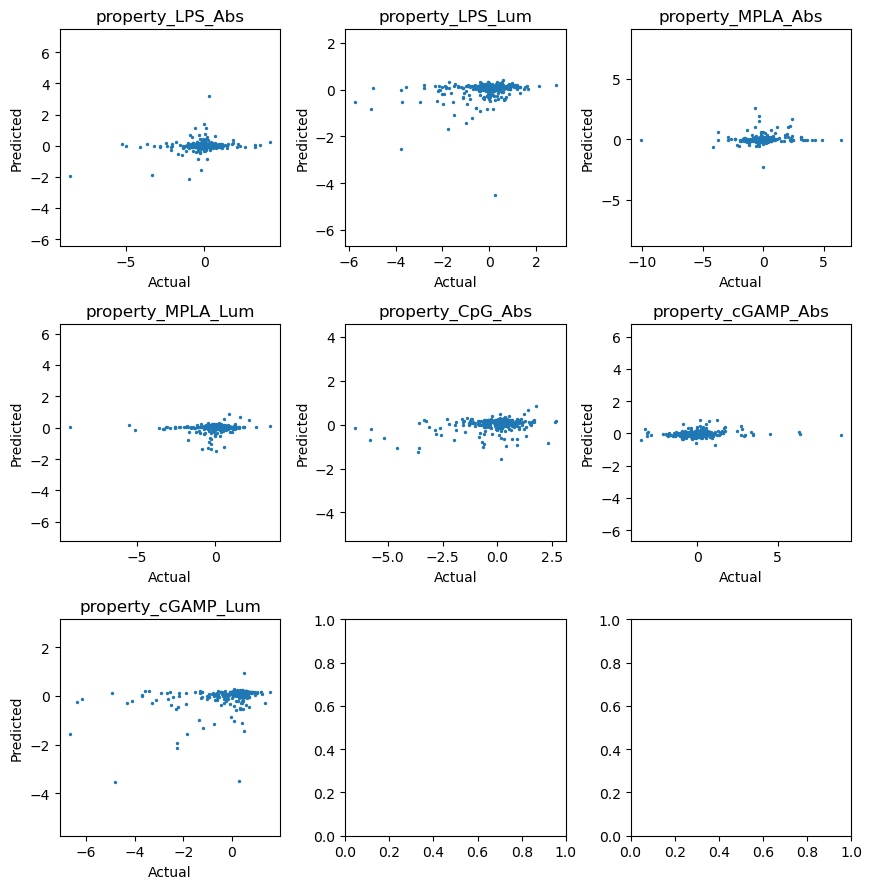

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flatten()

for i, property_label in enumerate(properties):

    ax = axs[i]

    ax.scatter(test_Y.iloc[:, i], test_predictions.iloc[:, i], s=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(property_label)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()

In [8]:
#fig.savefig('./figures/predictions.pdf')